# P4 Panoramas and Stereo

### P4.1 Spherical Reprojection

As we discussed in class, to make a panorama we need to reproject the images onto a sphere, something you will be implementing in this question. I have given you some starter code that you should use to reproject the image onto a sphere: the function `reproject_image_to_sphere`. I have annotated what you need to include to complete this function:

<img src="annotated_projection_code.png" width="600">

**TASK** Complete the `reproject_image_to_sphere` function I have provided below. I recommend that you revisit the lecture slides on panoramas to get the definitions of the unit sphere coordinates.

I have provided you with a simple scene for Blender: `simple_pano_env.blend`. The camera is located at `x=0` and `y=0` and oriented such that it is level with the ground plane and rotated 0-degrees about the z-axis. The only camera in the scene has a Focal Length of 40 mm (expressed with respect to the *36 mm* film size standard used in photography). To test that your image reprojection method is working correctly.

**TASK** Generate 4 images by changing the Focal Length of the camera in Blender and name them as follows:

1. `b_pano_20mm.png` Rendered after setting the camera Focal Length to `20 mm`.
2. `b_pano_30mm.png` Rendered after setting the camera Focal Length to `30 mm`.
3. `b_pano_40mm.png` Rendered after setting the camera Focal Length to `40 mm`.
4. `b_pano_50mm.png` Rendered after setting the camera Focal Length to `50 mm`.

**Plots** Run the `Evaluation and Plotting` code I have included below. This will generate three figures (all of which you should include in your writeup). (1) shows the four images after the spherical reprojection. (2) shows the images added together, showing that in the center where all images have visibility of the scene, the images properly overlap. (3) The "differences" between consecutive Focal Lengths; if your code is implemented well, the center region (where the two overlap) should be nearly zero ("white" in the color scheme) and large outside of that image (where they do not overlap).

If the second plot, in which all images have been added together, looks "reasonable" (that the images are properly overlapped with one another) and you are convinced that your reprojection function is working properly, you can move on to the next section, in which you are asked to build your own panoramas after reprojecting onto a sphere.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.interpolate

# Helper Functions
def load_image_gray(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(np.float)/255
    if len(img.shape) > 2:
        return img[:, :, 0]
    else:
        return img

def get_image_with_f(filepath, blender_focal_length_mm):
    image = load_image_gray(filepath)
    f = max(image.shape) * blender_focal_length_mm / 36.00
    return image, f

# Starter code for P4.1 (replace the None's in the loop)
def reproject_image_to_sphere(image, focal_length_px, fov_deg=None, angular_resolution=0.01):
    # Notice that because matrices are stored "rows, columns",
    # we need to flip the "shape" coordinates so that the transformation
    # matrix does what we expect. The other convention is also acceptable,
    # as long as one is consistent. In this function, the transformation
    # matrix is assumed to be in [x, y, w] coordinates, even though the image
    # is stored in row, column (y, x) coordinates.
    x = np.arange(image.shape[1]).astype(np.float)
    y = np.arange(image.shape[0]).astype(np.float)
    
    # Compute the thetas and phis of the output plane
    if fov_deg is None:
        fov = np.arctan(max(image.shape)/focal_length_px/2) + angular_resolution
    else:
        fov = fov_deg * np.pi / 180
    
#     print(f"2 * Field of View: {2*fov}")
    thetas = np.arange(-fov, fov, angular_resolution)
    phis = np.arange(-fov, fov, angular_resolution)

    # Perform the interpolation
    transformed_image = np.zeros((len(phis), len(thetas)))
    image_fn = scipy.interpolate.interp2d(x, y, image, kind='linear', fill_value=0)
    for ii in range(len(thetas)):
        for jj in range(len(phis)):
            theta = thetas[ii]
            phi = phis[jj]
            
            xt = np.sin(theta)*np.cos(phi)
            yt = np.sin(phi)
            zt = np.cos(theta)*np.cos(phi)
            
            new_x = len(x)//2 + focal_length_px * xt//zt
            new_y = len(y)//2 + focal_length_px * yt//zt
            transformed_image[jj, ii] = image_fn(new_x, new_y)
    
    return transformed_image


img_20, f_20 = get_image_with_f('b_pano_20mm.png', 20)
img_30, f_30 = get_image_with_f('b_pano_30mm.png', 30)
img_40, f_40 = get_image_with_f('b_pano_40mm.png', 40)
img_50, f_50 = get_image_with_f('b_pano_50mm.png', 50)

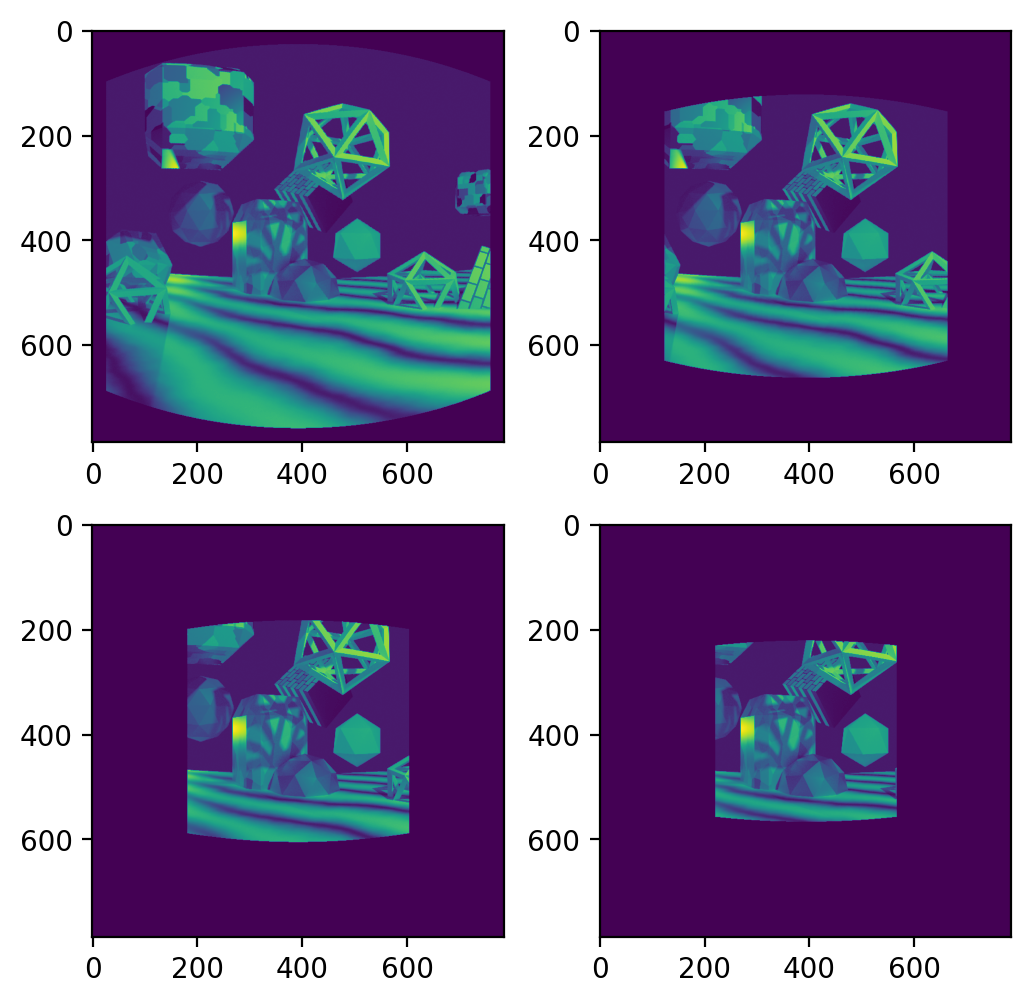

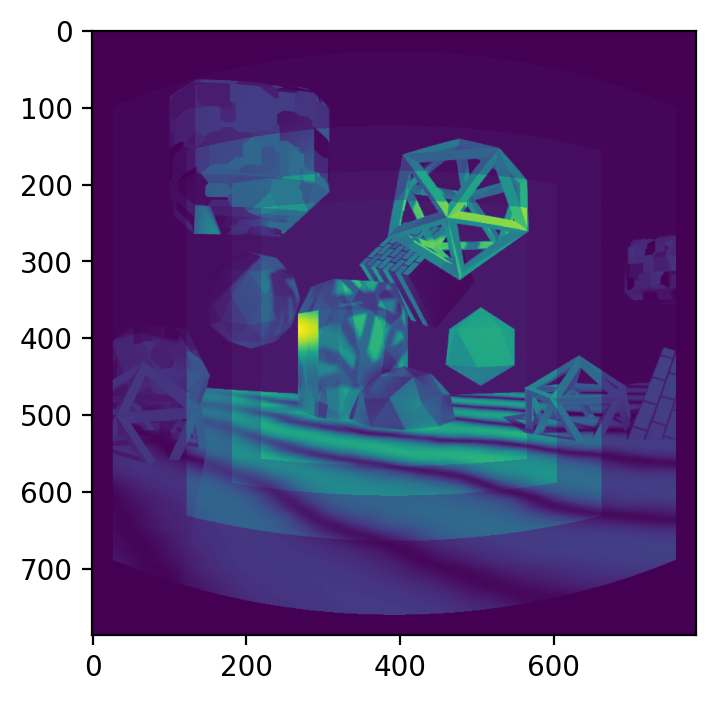

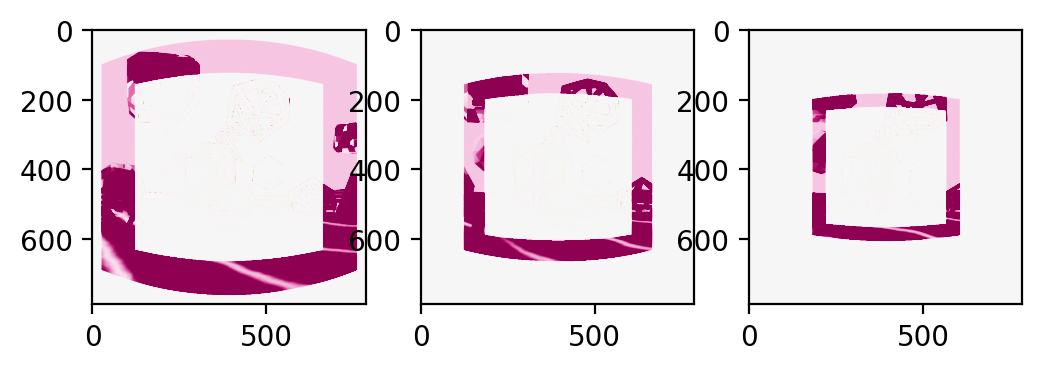

In [13]:
# Evaluation and Plotting Code

sp_img_20 = reproject_image_to_sphere(img_20, f_20, fov_deg=45, angular_resolution=0.002)
sp_img_30 = reproject_image_to_sphere(img_30, f_30, fov_deg=45, angular_resolution=0.002)
sp_img_40 = reproject_image_to_sphere(img_40, f_40, fov_deg=45, angular_resolution=0.002)
sp_img_50 = reproject_image_to_sphere(img_50, f_50, fov_deg=45, angular_resolution=0.002)

plt.figure(figsize=(6,6), dpi=200)
plt.subplot(2, 2, 1)
plt.imshow(sp_img_20)
plt.subplot(2, 2, 2)
plt.imshow(sp_img_30)
plt.subplot(2, 2, 3)
plt.imshow(sp_img_40)
plt.subplot(2, 2, 4)
plt.imshow(sp_img_50)

plt.figure(dpi=200)
plt.imshow(sp_img_20 + sp_img_30 + sp_img_40 + sp_img_50)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(sp_img_30 - sp_img_20, vmin=-0.2, vmax=0.2, cmap='PiYG')
plt.subplot(1, 3, 2)
plt.imshow(sp_img_40 - sp_img_30, vmin=-0.2, vmax=0.2, cmap='PiYG')
plt.subplot(1, 3, 3)
plt.imshow(sp_img_50 - sp_img_40, vmin=-0.2, vmax=0.2, cmap='PiYG')

# P4.2 Panorama Stitching

In this question, you will be building a panorama from images you generate from Blender. This will involve three steps: (1) image generation, (2) image transform estimation, and (3) stitching.

**TASK** Generate images from Blender. To do this, you may using the `simple_pano_env.blend` environment that I have provided you with. By rotating the camera (done by modifying the rotation about its Z-axis). You should set the Focal length of the camera to `40 mm` and sweep the rotation from +40 degrees to -60 degrees; you should rotate the camera in increments such that consecutive images have an overlap of roughly 1/3. You will likely need to generate roughly 5 or 6 images in this range.

**PLOTS** Reproject the images using the `reproject_image_to_sphere` function from the previous question and compute the translation transform between each pair of "consecutive images" (images next to one another in angle space) using OpenCV. For each pair of matched images 

To compute the transformation, you may use the same [OpenCV Homography tutorial from the last assignment](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html). However, we know that the transformation is a translation, and so we do not want to allow the system to generate a general homography matrix, which is what results with `cv.findHomography`. Instead, you should use `affine_mat = cv.estimateAffinePartial2D(src_pts, dst_pts)[0]`, which returns a `2x3` matrix (you will need to convert this to a `3x3` homography by adding a row of `[0, 0, 1]`) that only allows for scale, rotation, and translation. Create a new transformation matrix that includes only the estimated translation parameters. Using this procedure should be more numerically stable.

**PLOT** Create the panorama and include it in a plot! To do this you should:

1. Pad all images to the size of the output panorama (you will need to determine how wide this will need to be).
2. Apply the transformation matrices (using `cv.warpPerspective`) to the images to move them "into place" (the location they will be in the resulting panorama). This means that you will need to apply `translation_mat_2_to_1` (or its inverse) to shift image 2 relative to image 1. Note that moving image 3 into place will require accounting for the translation between 2 and 3 *and* the translation between 1 and 2, and so on. You should prefer to multiply the transformation matrices together before using them to transform the image.
3. Combine the images to make the panorama. You do not need to use any of the "fancy" blending techniques we discussed in class. Simply using `np.maximum` between the two images will create a sufficient panorama. Small artifacts from merging are acceptable.

**PLOT** Finally, add the 20 mm focal length image you generated as part of the previous question to your panorama. It might be interesting to see how the significant change in field of view reveals more of the panorama at once and more of the space above and below the horizon. Combined, your images should look like a "wide plus" (something like this):

```
        +----+
+-------+    +-------+
|                    | 
+-------+    +-------+
        +----+
````

where the taller region in the middle is filled in by the 20 mm image (which has a wider field of view). Include this combined image in your writeup.

(786, 1650)


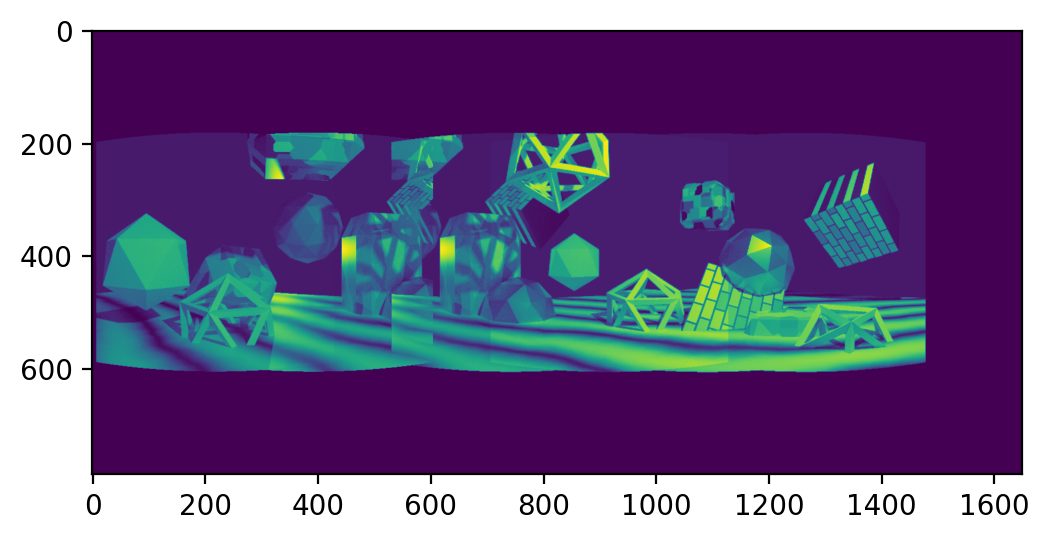

In [14]:
import cv2 as cv
from PIL import Image

img_pano_40, f_40 = get_image_with_f('b_pano_40.png', 40)
img_pano_20, f_40 = get_image_with_f('b_pano_20.png', 40)
img_pano_0, f_40 = get_image_with_f('b_pano_0.png', 40)
img_pano_n20, f_40 = get_image_with_f('b_pano_n20.png', 40)
img_pano_n40, f_40 = get_image_with_f('b_pano_n40.png', 40)
img_pano_n60, f_40 = get_image_with_f('b_pano_n60.png', 40)

image_40 = load_image_gray('reprojection_40.png')
image_20 = load_image_gray('reprojection_20.png')
image_0 = load_image_gray('reprojection_0.png')
image_n20 = load_image_gray('reprojection_n20.png')
image_n40 = load_image_gray('reprojection_n40.png')
image_n60 = load_image_gray('reprojection_n60.png')

#Compute translation transformation for each pair of matched images
def computeTranslation(img1, img2):
    MIN_MATCH_COUNT = 10
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        #transformation matrix
        affine_mat = cv.estimateAffinePartial2D(src_pts, dst_pts)[0]
        
        #Adding [0,0,1] row to the affine matrix
        affine_mat = np.append(affine_mat,[[0,0,1]], axis = 0)
        #print(affine_mat)
        return affine_mat
    
def getStableMatrix(M):
    M[0][0] = 1.0
    M[0][1] = 0.0
    M[1][0] = 0.0
    M[1][1] = 1.0
    return M

def transform_image(image, tmat):
    import cv2
    return cv2.warpPerspective(
        image, 
        np.array(tmat).astype(float), 
        dsize=(image.shape[1], image.shape[0]))

def pad(img):
    newImage = np.zeros((img.shape[0], 1650))
    for x in range(img.shape[0]):
        for y in range(img.shape[0]):
            newImage[y][x] = img[y][x]
    return newImage

#Compute translation matrix between 40 and 20
image_40_8bit = cv.normalize(image_40, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
image_20_8bit = cv.normalize(image_20, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
translationTransformation_40_20 = computeTranslation(image_40_8bit, image_20_8bit)
translationTransformation_40_20 = getStableMatrix(translationTransformation_40_20)
# print("1:\n",translationTransformation_40_20)

#Compute translation matrix between 20 and 0
image_0_8bit = cv.normalize(image_0, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
translationTransformation_20_0 = computeTranslation(image_20_8bit, image_0_8bit)
translationTransformation_20_0 = getStableMatrix(translationTransformation_20_0)
# print("2:\n",translationTransformation_20_0)

#Compute translation matrix between 0 and -20
image_n20_8bit = cv.normalize(image_n20, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
translationTransformation_0_n20 = computeTranslation(image_0_8bit, image_n20_8bit)
translationTransformation_0_n20 = getStableMatrix(translationTransformation_0_n20)
# print("3:\n", translationTransformation_0_n20)

#Compute translation matrix between -20 and -40
image_n40_8bit = cv.normalize(image_n40, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
translationTransformation_n20_n40 = computeTranslation(image_n20_8bit, image_n40_8bit)
translationTransformation_n20_n40 = getStableMatrix(translationTransformation_n20_n40)
# print("4:\n", translationTransformation_n20_n40)

#Compute translation matrix between -40 and -60
image_n60_8bit = cv.normalize(image_n60, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
translationTransformation_n40_n60 = computeTranslation(image_n40_8bit, image_n60_8bit)
translationTransformation_n40_n60 = getStableMatrix(translationTransformation_n40_n60)
# print("5:\n", translationTransformation_n40_n60)

pano = np.zeros((image_40_8bit.shape[0], 1650)) #Should be (786, 1650)
print(pano.shape)

def createPanorama(pano, img1, img2, img3, img4, img5, img6, m1, m2, m3, m4, m5):
    img1 = pad(img1)
    img2 = pad(img2)
    img3 = pad(img3)
    img4 = pad(img4)
    img5 = pad(img5)
    img6 = pad(img6)
        
    img1 = transform_image(img1, m1)
    pano = np.maximum(img1, img2)
    
    matrix1_2 = np.matmul(m2,m1)
    img3 = transform_image(img3, np.linalg.inv(matrix1_2))
    pano = np.maximum(pano, img3)
    
    matrix2_3 = np.matmul(m3, matrix1_2)
    img4 = transform_image(img4, np.linalg.inv(matrix2_3))
    pano = np.maximum(pano, img4)
    
    matrix3_4 = np.matmul(m4, matrix2_3)
    img5 = transform_image(img5, np.linalg.inv(matrix3_4))
    pano = np.maximum(pano, img5)
    
    matrix4_5 = np.matmul(m5, matrix3_4)
    img6 = transform_image(img6, np.linalg.inv(matrix4_5))
    pano = np.maximum(pano, img6)
            
    return pano
    
panorama = createPanorama(pano,image_40_8bit,image_20_8bit,image_0_8bit,image_n20_8bit,image_n40_8bit,image_n60_8bit, translationTransformation_40_20, 
                          translationTransformation_20_0, translationTransformation_0_n20, 
                          translationTransformation_n20_n40, translationTransformation_n40_n60)

plt.figure(dpi=200)
plt.imshow(panorama)

## P4.3 Triangulation 

In class, we discussed how you could extract information about a 3D scene given two cameras and their camera projection matrices. Here, we will investigate a simple example to learn the fundamentals.

### P4.3.1 Projecting Into Image Space

Below, I have provided you with two images taken by two cameras `a` and `b`. In this question, we will go over some camera basics, namely how to compute the image-space point from a 3D point in the scene and the known camera matrices.

Some information about the two camera matrices:
- The first camera is translated such that `t_a = [0, -0.2, 5]` and `t_b = [-1.5, 0, 5]`
- No rotation is applied to either camera (so the rotation matrix is the identity matrix)
- The focal length of the camera (for these 1024 px) images is `f = 1170.3` (in units of pixels).
- The camera center is located at the center of the image.

**QUESTION** What are the camera matrices $P_a$ and $P_b$? I will accept either the final matrix, or the matrix written in terms of its component matrices (the intrinsic and extrinsic matrices), as long as these are defined.

I have provided you with a single point below in 3D space `X0` that exists on one of the corners of the cube shown in the scene.

**TASK + PLOTS** Implement the function `get_projected_point(P, X)` which takes in a camera matrix `P` and a 3D scene point `X`. If your matrices are implemented correctly, you should see that the projected 3D point overlaps with one of the corners of the cube in image space. Include the two images with the point `X0` projected onto the two images.

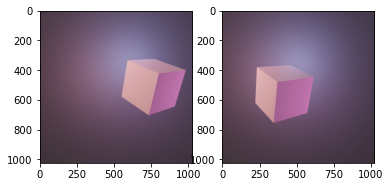

In [15]:
## Starter code
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(np.float)/255
    return img[:, :, :3]

image_a = load_image('two_view_cube_image_a.png')
image_b = load_image('two_view_cube_image_b.png')
plt.figure()
plt.subplot(121)
plt.imshow(image_a)
plt.subplot(122)
plt.imshow(image_b)

In [21]:
# TASK: Implement the camera matrices & get_projected_point
f = 1137.8
#f = 1170.3

Rt_a = np.array([
    [1, 0, 0, 0], 
    [0, 1, 0, -0.2], 
    [0, 0, 1, 5]
])

Rt_b = np.array([
    [1, 0, 0, -1.5], 
    [0, 1, 0, 0], 
    [0, 0, 1, 5]
])

Camera = np.array([
    [f, 0, 512], 
    [0, f, 512], 
    [0, 0, 1]
])

Pa = np.dot(Camera, Rt_a)
print(Pa)
Pb = np.dot(Camera, Rt_b)
print(Pb)

X0 = np.array([ 0.85244616, 0.9508618, -0.51819406])
points_3D = [X0]

def get_projected_point(P, X):
    X = np.append(X, 1)
    a = np.dot(P, X)
    x = np.array([a[0]/a[2], a[1]/a[2]])
    return x

[[1.13780e+03 0.00000e+00 5.12000e+02 2.56000e+03]
 [0.00000e+00 1.13780e+03 5.12000e+02 2.33244e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00 5.00000e+00]]
[[1.1378e+03 0.0000e+00 5.1200e+02 8.5330e+02]
 [0.0000e+00 1.1378e+03 5.1200e+02 2.5600e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00 5.0000e+00]]


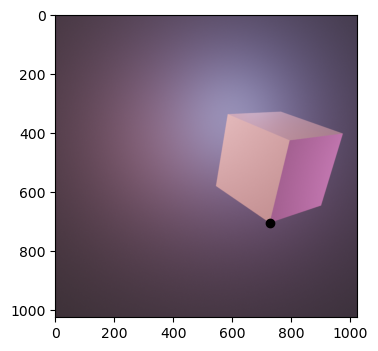

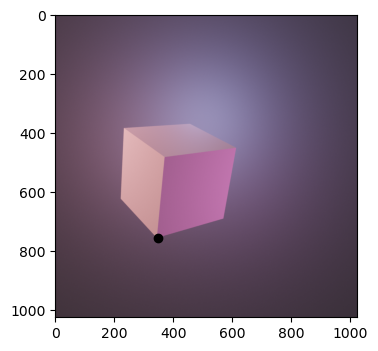

In [17]:
## Plotting Code
if Pa is None or Pb is None:
    raise NotImplementedError("Define the camera matrices.")

def visualize_projected_points(image, P, points_3D, verbose=False):
    plt.figure(dpi=100)
    plt.imshow(image)
    for X in points_3D:
        x = get_projected_point(P, X)
        if verbose:
            print(x)
        plt.plot(x[0], x[1], 'ko')

visualize_projected_points(image_a, Pa, points_3D)
visualize_projected_points(image_b, Pb, points_3D)

### P4.3.2 Determining the Size of the Cube

Now you will invert this operation. In class, we discussed how to triangulate a point from two correspondences. The relevant slide from L15 (two-view modeling) is as follows:

<img src="triangulation_lin_alg.png" width="400">

(*Note*: I have used `Pa` and `Pb` to denote the image matrices, whereas the included slide uses $p$ and $p'$.) You can use SVD to solve for the "best" value of the 3D point $X$ (equivalently, you can find the minimum eigenvector of $A^T A$). Manually determine the (x, y) coordinates of two corners in the provided images (from the upper left corner) and use them as part of this triangulation procedure. By finding the 3D point corresponding to two of the corners and computing the distance between them, you should be able to compute the size of the cube in the images.

**TASK** Pick two corners of the cube and include the $(x, y)$ image coordinates for both `image_a` and `image_b` and the 3D world coordinate $(X, Y, Z)$ in your writeup.

**QUESTION** What is the side length of the cube shown in the two images above? (The answer might be somewhat sensitive to the coordinates you measure in image space, though we are only looking for a "close enough" number within maybe 10%–20% of the "correct" answer. You should feel free to use more than two points and average the results to get a more accurate result.)

You can confirm that your estimated 3D coordinates are correct by reprojecting them back into image space using your solution from the previous question to check for accuracy.

> **We will use your full response to evaluate partial credit, so be sure to enumerate the steps you took and (if you feel it helpful) intermediate results or code snippets.**

[1.77195723 0.81604985 0.15646519]
[ 1.91903588 -0.24615024 -0.28324128]
1.1536955839418352


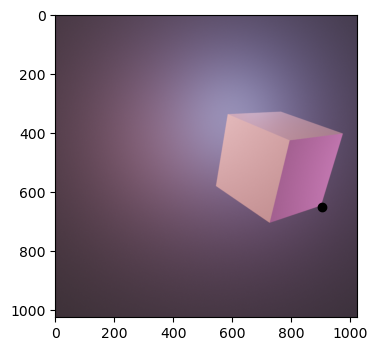

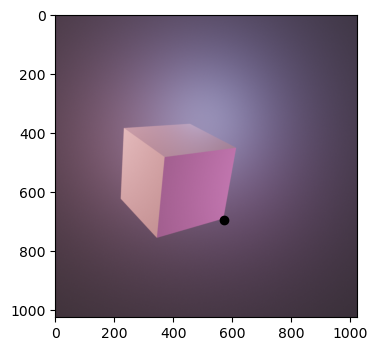

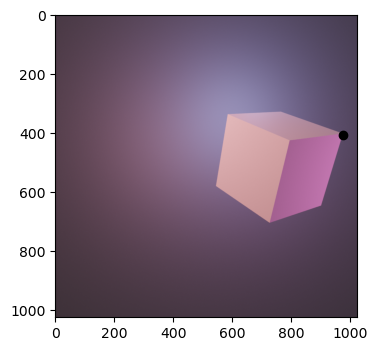

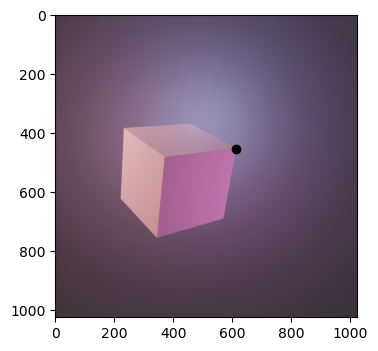

In [18]:
import math
def solve_3Dpoint(ImagePointA, ImagePointB): #Uses triangularity to compute 3D point from two 2D image coordinates from two different cameras
    
    Ap1 = Pa[0,0:]
    Bp1 = Pb[0,0:]
    Ap2 = Pa[1,0:]  #Grabbing rows from camera matricies to be used in A matrix
    Bp2 = Pb[1,0:]
    Ap3 = Pa[2,0:]
    Bp3 = Pb[2,0:]
    
    A = np.zeros((4,4))
    b = np.zeros((4))
    
    A[0,0:] = np.dot(ImagePointA[1], Ap3) - Ap2
    A[1,0:] = (Ap1 - np.dot(ImagePointA[0], Ap3))   
    A[2,0:] = (np.dot(ImagePointB[1], Bp3) - Bp2) #Building A matrix
    A[3,0:] = (Bp1 - np.dot(ImagePointB[0], Bp3))
    
    A_T_A = np.dot(A.T, A)
    eigen_values, eigen_vectors = np.linalg.eig(A_T_A)  #Compute 3D coordinate by taking eignevector with smallest eignevalue of A
    h = eigen_vectors[:, np.argmin(eigen_values)]
    h = h/h[3] #Normalize
    return h

ImgPoint1A = (903, 648)
ImgPoint1B = (572, 692)   #Manually selected 2D image points
ImgPoint2A = (975, 405)
ImgPoint2B = (613, 452)

tmp = solve_3Dpoint(ImgPoint1A, ImgPoint1B)
point1_3D = np.array([ tmp[0], tmp[1], tmp[2]]) #Find 3D point of first 2D point
solved1_3D = [point1_3D]
print(point1_3D)

tmp = solve_3Dpoint(ImgPoint2A, ImgPoint2B)
point2_3D = np.array([ tmp[0], tmp[1], tmp[2]]) #Find 3D point of second 2D point
solved2_3D = [point2_3D]
print(point2_3D)

visualize_projected_points(image_a, Pa, solved1_3D)
visualize_projected_points(image_b, Pb, solved1_3D) #Use function from part 1 to confirm our found 3D points are accurate
visualize_projected_points(image_a, Pa, solved2_3D)
visualize_projected_points(image_b, Pb, solved2_3D)

#Compute side length of cube
distanceSide1 = math.sqrt(math.pow(X0[0] - point1_3D[0], 2) + math.pow(X0[1] - point1_3D[1], 2) + math.pow(X0[2] - point1_3D[2], 2))
distanceSide2 = math.sqrt(math.pow(point1_3D[0] - point2_3D[0], 2) + math.pow(point1_3D[1] - point2_3D[1], 2) + math.pow(point1_3D[2] - point2_3D[2], 2))
SideLength = (distanceSide1 + distanceSide2)/2
print(SideLength)

## P4.4 Stereo Patch Matching

Now I have provided you with a stereo pair of images (already rectified) and a handful of features in one of the images. Your job is to locate the locations of the corresponding features in the other image using *patch match stereo* as we discussed in class. I have provided you with some starter code in the function `patch_match_stereo` below, which iterates through the possible locations

**QUESTION** The possible feature matches in the second image are along the epipolar line. Since the images are properly rectified, what is the epipolar line in the second image corresponding to coordinate `(x_a, y_a)` in the first image?

**TASK** Define the `possible_coordinates` vector in the `patch_match_stereo` function using your answer. Once that is defined, the `patch_match_stereo` function will loop through all possible feature coordinates in the second image and return the coordinate with the best *match_score*.

**TASK** Implement the function `compute_match_score_ssd` (Sum of Squared Differences) using the formula we discussed in class: $$ \text{response} = -\sum_{k,l} (g_{kl} - f_{kl})^2, $$ where $g$ is the patch from `image_a` and $f$ is the patch from `image_b`. If this function is correctly implemented, you should see some of the features are aligned between the two images.

**TASK** Implement the function `compute_match_score_ncc` (Normalized Cross Correlation) using the formula: $$ \text{response} = \frac{\sum_{k,l}(g_{kl} - \bar{g})(f_{kl} - \bar{f})}{\sqrt{\sum_{kl}(g_{kl} - \bar{g})^2}\sqrt{\sum_{kl}(f_{kl} - \bar{f})^2}}$$

Once you have implemented these functions, you should run the plotting code I have included below, which computes a disparity map over the entire image. 

> **NOTE: this will take a long time to run, so be sure that you confirm that your code is working properly first. You may want to test using the code from the breakout session L16B first. In addition, you should make an effort to use vectorized/Numpy operations to implement the matching functions. For example, using `np.sum(A)` or `A.sum()` is considerably faster than using a for loop. Using Numpy functions will make an order-of-magnitude difference in the amount of time it takes to run the code below. Functions that may come in handy include `np.mean` and `np.std`.**

**PLOTS** Include in your writeup the depth plots generated by each of the two match scores generated by the code below in the code block beginning with `# Compute and plot the depth maps`.

**QUESTION** The left few columns of both depth maps is quite noisy and inaccurate. Give an explanation for why this is the case?

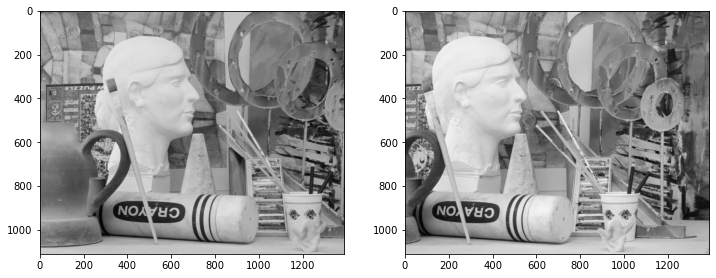

In [19]:
# Data from https://vision.middlebury.edu/stereo/data/scenes2005/
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import scipy.signal
import cv2


# Load the images
def load_image_gray(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(np.float)/255
    if len(img.shape) > 2:
        return img[:, :, 0]
    else:
        return img

image_a = load_image_gray('art_view0.png')
image_b = load_image_gray('art_view5.png')

## Plotting Code
plt.figure(figsize=(12, 5))
ax_a = plt.subplot(1, 2, 1)
plt.imshow(image_a, cmap='gray')
ax_b = plt.subplot(1, 2, 2)
plt.imshow(image_b, cmap='gray')


def get_patch(image, x, y, patch_half_width):
    return image[y-patch_half_width:y+patch_half_width+1,
                 x-patch_half_width:x+patch_half_width+1]

def compute_match_score_ssd(patch_a, patch_b):
    return -((patch_a-patch_b)**2).sum()
#     raise NotImplementedError("Define the patch match score")
    
def compute_match_score_ncc(patch_a, patch_b):
    numerator = ((patch_a-patch_a.mean())*(patch_b-patch_b.mean())).sum()
    denom = np.sqrt(((patch_a-patch_a.mean())**2).sum()) * np.sqrt(((patch_b-patch_b.mean())**2).sum())
    return numerator/denom
#     raise NotImplementedError("Define the patch match score")

def patch_match_stereo(image_a, image_b, x_a, y_a,
                       match_score_fn,
                       patch_half_width=9):
    """Returns the location of a feature/patch between stereo images.
    Inputs are the x, y coordinates of the patch in image_a.
    Outputs are the x, y coordinates of the patch in image_b."""

    # (1) Get the patch in image a
    patch_a = get_patch(image_a, x_a, y_a, 
                        patch_half_width=patch_half_width)

    # (2) Compute the responses along the epipolar line in image b
    # Define the possible coordinates along with the match might be found
    # (You should feel free to modify this code if you have a simpler
    # way to represent this operation.)
    xs = range(phw, image_b.shape[1] - phw)
    ys = [y_a] * len(xs)
    possible_coordinates = list(zip(xs,ys))
    if possible_coordinates is None:
        raise NotImplementedError()

    response = np.zeros((len(possible_coordinates)))
    for ind, (x_b, y_b) in enumerate(possible_coordinates):
        # Get the patch
        patch_b = get_patch(image_b, x_b, y_b,
                            patch_half_width=patch_half_width)
        # Compute the match score & store
        response[ind] = match_score_fn(patch_a, patch_b)
    
    # (3) Compute the maximum response
    ind = np.argmax(response)
    x_b, y_b = possible_coordinates[ind]

    return x_b, y_b, response[ind]

Text(0.5, 1.0, 'Depth Map (NCC)')

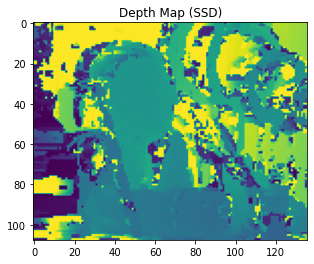

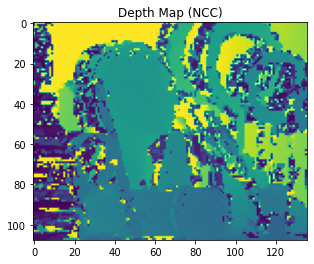

In [20]:
# Compute and plot the depth maps

phw = 15
spacing = 10

def compute_depth_map(image_a, image_b, match_score_fn):
    xs = range(phw, image_b.shape[1]-phw, spacing)
    ys = range(phw, image_b.shape[0]-phw, spacing)
    disparity_mat = np.zeros((len(ys), len(xs)))
    responses_mat = np.zeros((len(ys), len(xs)))
    for xi, x_a in enumerate(xs):
#         print(f"Progress: {xi}/{len(xs)}")
        for yi, y_a in enumerate(ys):
            x_b, y_b, response = patch_match_stereo(
                image_a, image_b, x_a, y_a, match_score_fn, patch_half_width=phw)
            dx = x_a - x_b
            dy = y_a - y_b
            disparity_mat[yi, xi] = np.sqrt(dx**2 + dy**2)
            responses_mat[yi, xi] = response

    # Compute and threshold the depth map
    depth = 1/(disparity_mat.copy() + 1e-5)
    depth[depth > 0.01] = 0.01
    return depth
    
plt.figure()
plt.imshow(compute_depth_map(image_a, image_b, compute_match_score_ssd))
plt.title('Depth Map (SSD)')

plt.figure()
plt.imshow(compute_depth_map(image_a, image_b, compute_match_score_ncc))
plt.title('Depth Map (NCC)')